Import the dataset

In [1]:
import pandas as pd
df = pd.read_csv('dataset/heart.csv')
df.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

1    165
0    138
Name: output, dtype: int64


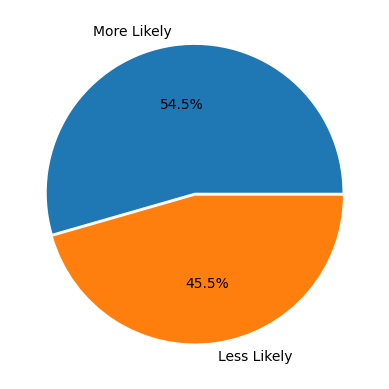

In [33]:
output_counts = df['output'].value_counts()
print(output_counts)

from matplotlib import pyplot as plt
plt.pie(output_counts, labels=['More Likely', 'Less Likely'], explode=[0.01, 0.01], autopct="%1.1f%%")
plt.show()

Attributes' types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
import attributes as attr

df.age.describe()

count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

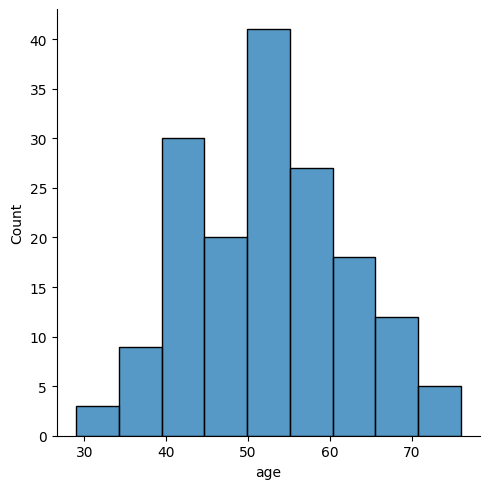

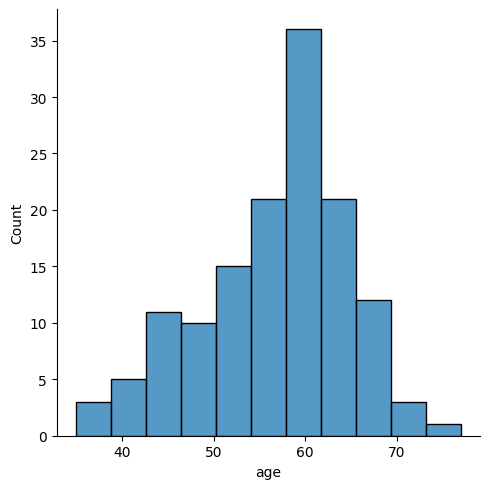

In [6]:
import seaborn as sns

likely_by_age = df[df['output'] == 1].age
sns.displot(likely_by_age)

not_likely_by_age = df[df['output'] == 0].age
sns.displot(not_likely_by_age)

In [7]:
from scipy.stats import shapiro
print(shapiro(likely_by_age))
print(shapiro(not_likely_by_age))

ShapiroResult(statistic=0.9867705702781677, pvalue=0.12113280594348907)
ShapiroResult(statistic=0.9686175584793091, pvalue=0.002868662355467677)


Après avoir executé les tests statistiques sur les deux:
- **Likely (by age):** \
    Etant donné que **pvalue > 0.05**, on peut dire que ces observations suivent la distribution normale.
- **Not likely (by age):** \
    Par contre, ici, **pvalue < 0.05**, donc ce n'est pas une distribution normale.